# Toxic comment analysis with NLP with RNN - Final Project

Reese Thompson, Feb 28th, 2025

### Problem and Data Analysis

This notebook will explore and analyze a set of toxic comments from a Wikipedia data set to train a model capable of identifying types of toxic comments, beyond just the binary classification.  The target value will ultimately be a probability that a comment is indeed toxic.

The initial data set includes a large set of comments that have been categorized accordingly.  We will use this data to build an NLP model using both LSTM RNN and GRU RNN.

Lets start by evaluating the data.

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_raw = pd.read_csv('data/train.csv')

train = train_raw.copy()

print("\nTrain Data Head:")
print(train.head())


Train Data Head:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


## EDA and Data Cleanup

We should also verify the distrobution of positive and negative cases.

In [30]:

missing_text = train['comment_text'].isnull().sum()
print(f"Missing text: {missing_text}")

Missing text: 0


/tmp/ipykernel_49464/1887761952.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


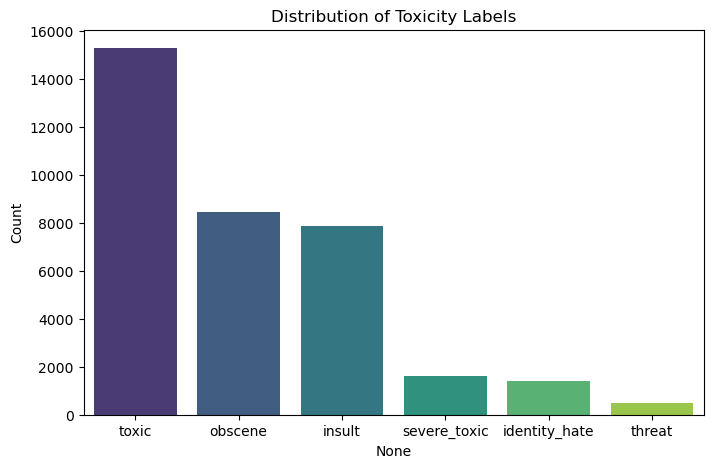

In [31]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

label_counts = train[labels].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title("Distribution of Toxicity Labels")
plt.ylabel("Count")
plt.show()

### Data Oversampling

We can see from the graph above that the data is heavily skewed, and there are 3 areas we may want to oversample to get a more accurate model.

First, we will want to clean our data set so that the oversampling proceedure can be simplified.

In [32]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def simple_clean(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = text.replace("\n", " ").replace("\r", " ").replace("\t", " ")
    return text

train['text'] = train['comment_text'].apply(simple_clean)
train = train.drop(columns=["comment_text"], axis=1)
train.head()

[nltk_data] Downloading package stopwords to /home/reese/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,text
0,0000997932d777bf,0,0,0,0,0,0,explanation why the edits made under my userna...
1,000103f0d9cfb60f,0,0,0,0,0,0,daww he matches this background colour im seem...
2,000113f07ec002fd,0,0,0,0,0,0,hey man im really not trying to edit war its j...
3,0001b41b1c6bb37e,0,0,0,0,0,0,more i cant make any real suggestions on impr...
4,0001d958c54c6e35,0,0,0,0,0,0,you sir are my hero any chance you remember wh...


In [33]:
train = train.drop(columns=['id'], axis=1)

train.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,text
0,0,0,0,0,0,0,explanation why the edits made under my userna...
1,0,0,0,0,0,0,daww he matches this background colour im seem...
2,0,0,0,0,0,0,hey man im really not trying to edit war its j...
3,0,0,0,0,0,0,more i cant make any real suggestions on impr...
4,0,0,0,0,0,0,you sir are my hero any chance you remember wh...


### Outliers

We will also want to remove any outliers, like very low character comments, or extremely long comments

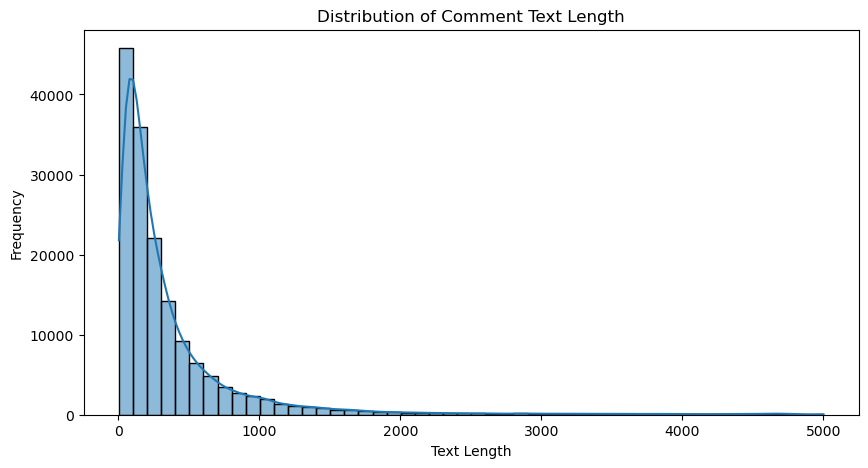

In [34]:
train['text_length'] = train['text'].apply(lambda x: len(str(x)))
plt.figure(figsize=(10, 5))
sns.histplot(train['text_length'], bins=50, kde=True)
plt.title("Distribution of Comment Text Length")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

In [35]:
import pandas as pd

mean_length = train['text_length'].mean()
median_length = train['text_length'].median()
mode_length = train['text_length'].mode()[0]

print(f"Mean Text Length: {mean_length}")
print(f"Median Text Length: {median_length}")
print(f"Mode Text Length: {mode_length}")

Mean Text Length: 377.8164578776845
Median Text Length: 196.0
Mode Text Length: 29


In [36]:
short = train[train['text'].str.len() < 10]

print("Number of comments under 10 characters:", short.shape[0])

short.head()

Number of comments under 10 characters: 9


,toxic,severe_toxic,obscene,threat,insult,identity_hate,text,text_length
19737,0,0,0,0,0,0,ps nair,7
52442,0,0,0,0,0,0,1453,4
58122,1,0,1,0,1,0,p u suck,9
93586,0,0,0,0,0,0,unblockyo,9
109985,0,0,0,0,0,0,unbloc,6


Short comments could actually still be toxic, so we will not remove - examples above.

In [37]:
long = train[train['text'].str.len() > 3000]

print("Number of comments over 3000 characters:", long.shape[0])

long.head()

Number of comments over 3000 characters: 1946


,toxic,severe_toxic,obscene,threat,insult,identity_hate,text,text_length
50,0,0,0,0,0,0,bi you said you wanted to talk at the botto...,3055
126,0,0,0,0,0,0,ahh hello witzeman 2039284161 symbols ...,3747
160,0,0,0,0,0,0,attributing and classifying of personalities ...,3824
214,0,0,0,0,0,0,randroide answers to next step guys i do ...,3735
321,0,0,0,0,0,0,661858580s rant presently we are witnessing...,4507


There are quite a few comments over 3000 characters.

For performance reasons, lets only account for the top 90% of comments (This may not be necessary based on compute resources)

In [38]:
length_90 = train['text_length'].quantile(0.90)
print(f"90th Percentile of Text Length: {length_90}")

90th Percentile of Text Length: 856.0


### 856 characters covers 90% of comments

In [39]:
train = train[train['text'].str.len() < 860]

### Oversampling

We are now ready to perform oversampling of the 3 categories that were underrepresented.  We will use a synthetic data approach, by adding comments that use synonyms and restructured sentences.

In [40]:
import random
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.corpus import wordnet

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ').lower()
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(comment, n=2):
    words = nltk.word_tokenize(comment)
    random_word_list = list(set(words))
    random.shuffle(random_word_list)
    
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            words = [synonym if word == random_word else word for word in words]
            num_replaced += 1
        if num_replaced >= n:
            break
    
    return ' '.join(words)

[nltk_data] Downloading package punkt to /home/reese/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/reese/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/reese/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [41]:
augmented_rows = []
for idx, row in train[train['identity_hate'] > 0].iterrows():
    text = row['text']
    for _ in range(5):
        new_text = synonym_replacement(text, n=2)
        new_row = row.copy()
        new_row['text'] = new_text
        augmented_rows.append(new_row)

augmented_df = pd.DataFrame(augmented_rows)
train = pd.concat([train, augmented_df], axis=0).reset_index(drop=True)


In [42]:
augmented_rows = []
for idx, row in train[train['severe_toxic'] > 0].iterrows():
    text = row['text']
    for _ in range(5):
        new_text = synonym_replacement(text, n=2)
        new_row = row.copy()
        new_row['text'] = new_text
        augmented_rows.append(new_row)

augmented_df = pd.DataFrame(augmented_rows)
train = pd.concat([train, augmented_df], axis=0).reset_index(drop=True)

In [43]:
augmented_rows = []
for idx, row in train[train['threat'] > 0].iterrows():
    text = row['text']
    for _ in range(15):
        new_text = synonym_replacement(text, n=2)
        new_row = row.copy()
        new_row['text'] = new_text
        augmented_rows.append(new_row)

augmented_df = pd.DataFrame(augmented_rows)
train = pd.concat([train, augmented_df], axis=0).reset_index(drop=True)

/tmp/ipykernel_49464/1887761952.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


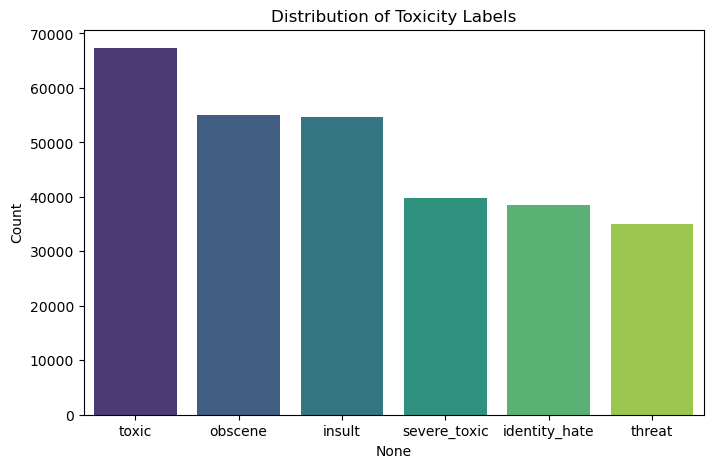

In [44]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

label_counts = train[labels].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title("Distribution of Toxicity Labels")
plt.ylabel("Count")
plt.show()

We now have a more balanced data set for training.

As a final step, lets review the correlation matrix to see if there are any major outliers.

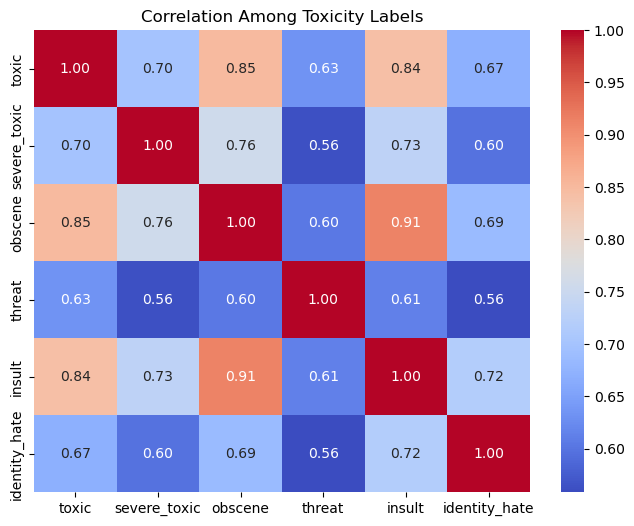

In [45]:
co_occurrence = train[labels].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(co_occurrence, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Among Toxicity Labels")
plt.show()

## Model setup

We will use both LSTM and GRU to test which approach yields the best result.  We will first need to tokenize the text data, using the Keras tokenizer.  In the code below, we set up a temp tokenizer to find the max vocabulary size we should use.

In [46]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from collections import Counter

X = train['text'].values

tokenizer_temp = Tokenizer(oov_token='<OOV>')
tokenizer_temp.fit_on_texts(X)

word_counts = tokenizer_temp.word_counts
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
total_count = sum(word_counts.values())
print(f"Total word count: {total_count}")

coverage_threshold = 0.97
running_count = 0
vocab_size_threshold = 0

for i, (word, count) in enumerate(sorted_word_counts):
    running_count += count
    if running_count / total_count >= coverage_threshold:
        vocab_size_threshold = i + 1
        break

print(f"Coverage threshold of {coverage_threshold} reached at vocab size: {vocab_size_threshold}")


Total word count: 7944300
Coverage threshold of 0.97 reached at vocab size: 28030


Now that we know the max vocabulary size, we can set up our data for training and testing.

Our model architecture for the project will be a straight forward LSTM implementation, having an embedding layer feeding into the LSTM layer, with a dropout layer added to prevent overfitting.  This output will then be fed to dense layer for interpreting the LSTM results, with a final dropout layer added.  The final output layer will be have 6 nodes with sigmoid activation to identify each of the six categories as a binary true or false.

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_texts = train['text'].astype(str).tolist()
train_labels = train[labels].values

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train_texts, 
    train_labels, 
    test_size=0.25, 
    random_state=42,
    stratify=train_labels
)

max_words = 28050
max_len = 900
embedding_dim = 128

tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_len, padding='post', truncating='post')

model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

model.add(LSTM(128, return_sequences=False))

model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(6, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

/home/reese/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [59]:
num_epochs = 5
batch_size = 512

history = model.fit(
    X_train_padded, 
    y_train, 
    validation_data=(X_val_padded, y_val),
    epochs=num_epochs, 
    batch_size=batch_size,
    verbose=1
)


Epoch 1/5
290/290 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - accuracy: 0.9914 - loss: 0.5512 - val_accuracy: 0.9915 - val_loss: 0.5478
Epoch 2/5
290/290 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - accuracy: 0.9912 - loss: 0.5481 - val_accuracy: 0.9915 - val_loss: 0.5479
Epoch 3/5
290/290 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - accuracy: 0.9914 - loss: 0.5497 - val_accuracy: 0.9915 - val_loss: 0.5478
Epoch 4/5
290/290 ━━━━━━━━━━━━━━━━━━━━ 29s 98ms/step - accuracy: 0.9913 - loss: 0.5483 - val_accuracy: 0.9915 - val_loss: 0.5479
Epoch 5/5
290/290 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - accuracy: 0.9917 - loss: 0.5496 - val_accuracy: 0.9915 - val_loss: 0.5479


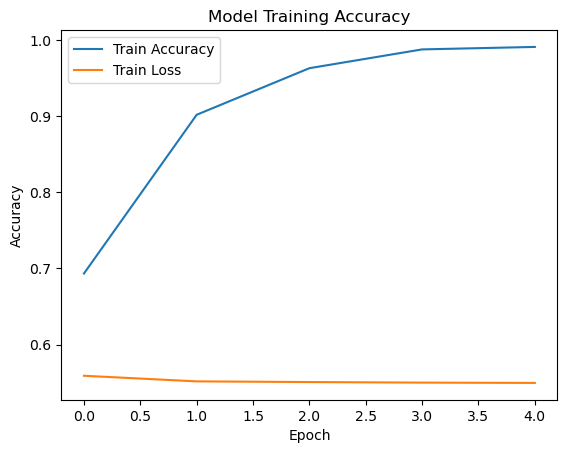

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Training Accuracy')
plt.legend()
plt.show()

In [ ]:

test_probs = model.predict(X_val_padded)
print(test_probs)


1543/1543 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step
[[0.34599662 0.21598355 0.2827576  0.18603177 0.28027496 0.20644222]
 [0.34599653 0.21598405 0.28275812 0.18603218 0.28027546 0.20644318]
 [0.34599668 0.2159839  0.28275782 0.18603235 0.2802753  0.20644243]
 ...
 [0.34599736 0.215984   0.28275928 0.18603285 0.28027645 0.20644318]
 [0.34599653 0.21598405 0.28275812 0.18603218 0.28027546 0.20644318]
 [0.34599736 0.215984   0.28275928 0.18603285 0.28027645 0.20644318]]


In [66]:
test_preds = (test_probs >= .5).astype(int)
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_val, test_preds)
print("Test Accuracy:", acc)

Test Accuracy: 0.6505084471093465


## Analysis and Hyperparameters

We can see from the results above that accuracy is around 65%.  We can now test LTSM vs GRU, as well as try to optimize our hyperparameters.

In [ ]:
def test_gru_model(embedding_dim, dropout, learning_rate, epochs, batch_size, first_layer_size, second_layer_size):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, 
                        output_dim=embedding_dim, 
                        input_length=max_len))
    model.add(GRU(first_layer_size, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(second_layer_size, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(6, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    history = model.fit(
        X_train_padded, 
        y_train, 
        validation_data=(X_val_padded, y_val),
        epochs=epochs, 
        batch_size=batch_size,
        verbose=1
    )

    best_train_acc = max(history.history['accuracy'])

    return best_train_acc

def test_lstm_model(embedding_dim, dropout, learning_rate, epochs, batch_size, first_layer_size, second_layer_size):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, 
                        output_dim=embedding_dim, 
                        input_length=max_len))
    model.add(GRU(first_layer_size, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(second_layer_size, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(6, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    history = model.fit(
        X_train_padded, 
        y_train, 
        validation_data=(X_val_padded, y_val),
        epochs=epochs, 
        batch_size=batch_size,
        verbose=1
    )

    best_train_acc = max(history.history['accuracy'])

    return best_train_acc


In [ ]:
gru_acc = test_gru_model(128, .3,.001, 3, 512, 100, 50)
lstm_acc = test_lstm_model(128, .3,.001, 3, 512, 100, 50)

print(f"LSTM - {lstm_acc}")
print(f"GRU - {gru_acc}")

/home/reese/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.4835 - loss: 0.5725 - val_accuracy: 0.9915 - val_loss: 0.5487
Epoch 2/3
290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.8825 - loss: 0.5516 - val_accuracy: 0.9915 - val_loss: 0.5489
Epoch 3/3
290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.9749 - loss: 0.5516 - val_accuracy: 0.9915 - val_loss: 0.5478
Epoch 1/3
290/290 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.6654 - loss: 0.5693 - val_accuracy: 0.9915 - val_loss: 0.5484
Epoch 2/3
290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - accuracy: 0.8912 - loss: 0.5512 - val_accuracy: 0.9915 - val_loss: 0.5480
Epoch 3/3
290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - accuracy: 0.9681 - loss: 0.5500 - val_accuracy: 0.9915 - val_loss: 0.5478
LSTM - 0.9752056002616882
GRU - 0.9789868593215942


There are too many hyperparameters to test in a full grid search, so we can perform a search to try to find optimals for each parameter individually

In [ ]:

from itertools import product

best_accuracy = 0
best_hypers = {}

embedding_dim_list = [64, 128, 256]
dropout_list = [0.2, 0.3, 0.5]
learning_rate_list = [0.001, 0.0001, 0.00001]
epochs_list = [2, 5, 10]
first_layer_size_list = [64, 128]
second_layer_size_list = [32, 64]

for emb in embedding_dim_list:
    accuracy = test_lstm_model(
            embedding_dim=emb,
            dropout=.2,
            learning_rate=.001,
            epochs=3,
            batch_size=512,
            first_layer_size=64,
            second_layer_size=32
        )
        
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hypers['embedding_dim'] = emb

print(best_hypers)


Epoch 1/3
290/290 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.6813 - loss: 0.5762 - val_accuracy: 0.9915 - val_loss: 0.5483
Epoch 2/3
290/290 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.8783 - loss: 0.5512 - val_accuracy: 0.9915 - val_loss: 0.5485
Epoch 3/3
290/290 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.9541 - loss: 0.5531 - val_accuracy: 0.9915 - val_loss: 0.5481
Epoch 1/3
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.4015 - loss: 0.5746 - val_accuracy: 0.9915 - val_loss: 0.5481
Epoch 2/3
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.9134 - loss: 0.5520 - val_accuracy: 0.9915 - val_loss: 0.5478
Epoch 3/3
290/290 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.9759 - loss: 0.5502 - val_accuracy: 0.9915 - val_loss: 0.5481
Epoch 1/3
290/290 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - accuracy: 0.5646 - loss: 0.5685 - val_accuracy: 0.9915 - val_loss: 0.5478
Epoch 2/3
290/290 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - accuracy: 0.8710 - loss: 0.5525 - val_accu

In [50]:
best_accuracy = 0
for e in epochs_list:
    accuracy = test_gru_model(
            embedding_dim=128,
            dropout=.2,
            learning_rate=.001,
            epochs=e,
            batch_size=512,
            first_layer_size=64,
            second_layer_size=32
        )
        
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hypers['epochs'] = e

print(best_hypers)

Epoch 1/2
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.6459 - loss: 0.5748 - val_accuracy: 0.9915 - val_loss: 0.5478
Epoch 2/2
290/290 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.8670 - loss: 0.5520 - val_accuracy: 0.9915 - val_loss: 0.5484
Epoch 1/5
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.6916 - loss: 0.5726 - val_accuracy: 0.9915 - val_loss: 0.5478
Epoch 2/5
290/290 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.8464 - loss: 0.5546 - val_accuracy: 0.9915 - val_loss: 0.5478
Epoch 3/5
290/290 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.9274 - loss: 0.5534 - val_accuracy: 0.9915 - val_loss: 0.5478
Epoch 4/5
290/290 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.9595 - loss: 0.5517 - val_accuracy: 0.9915 - val_loss: 0.5478
Epoch 5/5
290/290 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.9809 - loss: 0.5506 - val_accuracy: 0.9915 - val_loss: 0.5478
Epoch 1/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.5448 - loss: 0.5750 - val_acc

In [51]:
best_accuracy = 0
for drop in dropout_list:
    accuracy = test_gru_model(
            embedding_dim=128,
            dropout=drop,
            learning_rate=.001,
            epochs=4,
            batch_size=512,
            first_layer_size=64,
            second_layer_size=32
        )
        
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hypers['dropout'] = drop

print(best_hypers)

Epoch 1/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.6336 - loss: 0.5719 - val_accuracy: 0.9915 - val_loss: 0.5483
Epoch 2/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.8595 - loss: 0.5532 - val_accuracy: 0.9915 - val_loss: 0.5478
Epoch 3/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.9436 - loss: 0.5502 - val_accuracy: 0.9915 - val_loss: 0.5478
Epoch 4/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.9710 - loss: 0.5512 - val_accuracy: 0.9915 - val_loss: 0.5480
Epoch 1/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.5203 - loss: 0.5783 - val_accuracy: 0.9915 - val_loss: 0.5478
Epoch 2/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.8232 - loss: 0.5531 - val_accuracy: 0.9915 - val_loss: 0.5480
Epoch 3/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.9425 - loss: 0.5503 - val_accuracy: 0.9915 - val_loss: 0.5482
Epoch 4/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.9616 - loss: 0.5501 - val_accu

In [52]:
best_accuracy = 0
for learn in learning_rate_list:
    accuracy = test_gru_model(
            embedding_dim=128,
            dropout=.5,
            learning_rate=learn,
            epochs=4,
            batch_size=512,
            first_layer_size=64,
            second_layer_size=32
        )
        
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hypers['learn'] = learn

print(best_hypers)

Epoch 1/4


/home/reese/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.3666 - loss: 0.5892 - val_accuracy: 0.9915 - val_loss: 0.5483
Epoch 2/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.7139 - loss: 0.5564 - val_accuracy: 0.9915 - val_loss: 0.5493
Epoch 3/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.8568 - loss: 0.5543 - val_accuracy: 0.9915 - val_loss: 0.5481
Epoch 4/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.9369 - loss: 0.5510 - val_accuracy: 0.9915 - val_loss: 0.5479
Epoch 1/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.3311 - loss: 0.6474 - val_accuracy: 0.9915 - val_loss: 0.5634
Epoch 2/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.4646 - loss: 0.5894 - val_accuracy: 0.9915 - val_loss: 0.5551
Epoch 3/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.5219 - loss: 0.5806 - val_accuracy: 0.9915 - val_loss: 0.5526
Epoch 4/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.5763 - loss: 0.5745 - val_accuracy: 0.99

In [53]:

best_accuracy = 0
for fls in first_layer_size_list:
    accuracy = test_gru_model(
            embedding_dim=128,
            dropout=.5,
            learning_rate=.001,
            epochs=4,
            batch_size=512,
            first_layer_size=fls,
            second_layer_size=32
        )
        
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hypers['fls'] = fls

print(best_hypers)


Epoch 1/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.2740 - loss: 0.6003 - val_accuracy: 0.9915 - val_loss: 0.5498
Epoch 2/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.7181 - loss: 0.5590 - val_accuracy: 0.9915 - val_loss: 0.5482
Epoch 3/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.8782 - loss: 0.5560 - val_accuracy: 0.9915 - val_loss: 0.5483
Epoch 4/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.9673 - loss: 0.5525 - val_accuracy: 0.9915 - val_loss: 0.5480
Epoch 1/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.4370 - loss: 0.5868 - val_accuracy: 0.9915 - val_loss: 0.5482
Epoch 2/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - accuracy: 0.8177 - loss: 0.5575 - val_accuracy: 0.9915 - val_loss: 0.5480
Epoch 3/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.9626 - loss: 0.5535 - val_accuracy: 0.9915 - val_loss: 0.5479
Epoch 4/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.9898 - loss: 0.5517 - val_accu

In [54]:
best_accuracy = 0
for sls in second_layer_size_list:
    accuracy = test_gru_model(
            embedding_dim=128,
            dropout=.5,
            learning_rate=.001,
            epochs=4,
            batch_size=512,
            first_layer_size=128,
            second_layer_size=sls
        )
        
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hypers['sls'] = sls

print(best_hypers)


Epoch 1/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step - accuracy: 0.3598 - loss: 0.5927 - val_accuracy: 0.9915 - val_loss: 0.5501
Epoch 2/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.8354 - loss: 0.5610 - val_accuracy: 0.9915 - val_loss: 0.5486
Epoch 3/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.9583 - loss: 0.5535 - val_accuracy: 0.9915 - val_loss: 0.5478
Epoch 4/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.9870 - loss: 0.5522 - val_accuracy: 0.9915 - val_loss: 0.5478
Epoch 1/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.5672 - loss: 0.5803 - val_accuracy: 0.9915 - val_loss: 0.5480
Epoch 2/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - accuracy: 0.8827 - loss: 0.5533 - val_accuracy: 0.9915 - val_loss: 0.5483
Epoch 3/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.9782 - loss: 0.5519 - val_accuracy: 0.9915 - val_loss: 0.5482
Epoch 4/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.9905 - loss: 0.5506 - val_accu

# Review and conclusion

We now have a set of optimal parameters for running our GRU RNN on the Wikipedia comment data.  We can now verify our accuracy for the project to test our model.

In [55]:
model = Sequential()
model.add(Embedding(input_dim=max_words, 
                    output_dim=embedding_dim, 
                    input_length=max_len))
model.add(GRU(128, return_sequences=False))
model.add(Dropout(.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(6, activation='sigmoid'))

optimizer = Adam(learning_rate=.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(
    X_train_padded, 
    y_train, 
    validation_data=(X_val_padded, y_val),
    epochs=10, 
    batch_size=batch_size,
    verbose=1
)

print("Overall model accuracy on predicting comments by category:")
test_preds = (test_probs >= .5).astype(int)
test_probs = model.predict(X_val_padded)
acc = accuracy_score(y_val, test_preds)
print(acc)


Epoch 1/10


/home/reese/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.4611 - loss: 0.5793 - val_accuracy: 0.9915 - val_loss: 0.5479
Epoch 2/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.8598 - loss: 0.5529 - val_accuracy: 0.9915 - val_loss: 0.5493
Epoch 3/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.9479 - loss: 0.5514 - val_accuracy: 0.9915 - val_loss: 0.5479
Epoch 4/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.9850 - loss: 0.5511 - val_accuracy: 0.9915 - val_loss: 0.5478
Epoch 5/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.9914 - loss: 0.5485 - val_accuracy: 0.9915 - val_loss: 0.5480
Epoch 6/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - accuracy: 0.9912 - loss: 0.5505 - val_accuracy: 0.9915 - val_loss: 0.5478
Epoch 7/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.9914 - loss: 0.5495 - val_accuracy: 0.9915 - val_loss: 0.5478
Epoch 8/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.9914 - loss: 0.5470 - val_accurac